In [14]:
# %load_ext autoreload
# %autoreload 2
# from utils import *
# from Network import *
# basic packages
import numpy as np
import glob
# import h5py
import math
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import os
import copy
import time
from easydict import EasyDict as edict
# from tempfile import TemporaryDirectory
# torch packages
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

In [2]:
class FoVDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx])
        y = torch.tensor(self.y_data[idx])
        return x,y

def a_norm(Q, K, mask = None):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    
    if mask is not None:
        m.masked_fill(mask == 0, float("-1e20"))
    
    return torch.softmax(m , -1) #(batch_size, seq_length, seq_length)


def attention(Q, K, V, mask = None):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K, mask) #(batch_size, seq_length, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, head_dim)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, head_dim)
        self.key = Key(dim_val, head_dim)
        self.query = Query(dim_val, head_dim)
    
    def forward(self, x, kv = None, mask = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            output =  attention(self.query(x), self.key(x), self.value(x), mask)
        else:
            #Attention with x as Q, external vector kv as K an V (For decoder)
            output = attention(self.query(x), self.key(kv), self.value(kv), mask)
        
        return output #(batch_size, seq_length, head_dim)
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, head_dim))
        self.heads = nn.ModuleList(self.heads)
        self.fc = nn.Linear(n_heads * head_dim, dim_val, bias = False)
                      
    def forward(self, x, kv = None, mask = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv, mask = mask))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs [N, seq_len, dim_val]        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False) # [N,seq_len,head_dim]
    
    def forward(self, x):
        x = self.fc1(x)
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False) # [N,seq_len,head_dim]
    
    def forward(self, x):
        x = self.fc1(x)
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Query, self).__init__()        
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False)
    
    def forward(self, x):
        x = self.fc1(x)        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe) # [seq_len, dim_val]
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1) # x + [seq_len, dim_val]
        return x  

#TODO
class RelativePositionalEncoding(nn.Module):
    def __init__(self, seq_len, dropout=0.1, max_len=5000):
        super(RelativePositionalEncoding, self).__init__()
        self.seq_len = seq_len
        self.table = nn.Linear(seq_len, 2*seq_len)
        

    def forward(self, x):
        x = table(x)
        return x 

# checkpointing
def save_ckpt(path, model, optimizer, epoch, train_losses, val_losses):
    
#     torch.save({'net': network.state_dict(), 'opt': optimizer.state_dict()}, fn)
    path = f'{path}/epoch_{epoch}_batch_{BATCH_SIZE}_ckpts.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, path)

def load_ckpt(path, model, optimizer, device='cuda'):
    if device == 'cpu':
        checkpoint = torch.load(path,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

    model.eval()
    return model, optimizer

In [3]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, head_dim , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        # x: [N, enc_seq_len, dim_val]
        a = self.attn(x)
        x = self.norm1(x + a)
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a) # [N, enc_seq_len, dim_val]
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc, mask):
        # x: [N, dec_seq_len, dim_val]
        a = self.attn1(x, kv=None, mask = mask)
        x = self.norm1(a + x)
        a = self.attn2(x, kv = enc, mask = mask) # TODO check does this need mask?
        x = self.norm2(a + x)
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm3(x + a) # x: [N, dec_seq_len, dim_val]
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, feature_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1, pe_mode = 'standard', device='cuda'):
        """
            dim_val: d_model - 64
            head_dim: 16
            feature_size: feature size - 9
            dec_seq_len: length of decoder input sequence - 600
            out_seq_len: decoder output sequence length - 1 or 600?
            pe_mode: positional encoding mode - 'relative' or 'standard'
        """
        self.device=device
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = nn.ModuleList()
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, head_dim, n_heads))
        
        self.decs = nn.ModuleList()
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, head_dim, n_heads))
        
        if pe_mode == 'relative':
            self.pos = RelativePositionalEncoding(dim_val)
        else:
            self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
#         self.enc_input_fc = nn.Linear(feature_size, dim_val)
        self.enc_input_fc = nn.Sequential(
          nn.Linear(feature_size, dim_val//2),
          nn.ReLU(),
          nn.Linear(dim_val//2, dim_val),
        )
        self.dec_input_fc = nn.Linear(feature_size, dim_val)
#         self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
        self.out_fc = nn.Linear(dim_val, feature_size)

        
    def make_trg_mask(self, N, trg_len):
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
           N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, x, target=None):
        # x: [N, enc_seq_len, feature_size] = [8, 600, 9]
        # dec_input = [N, dec_seq_len, feature_size]
        
        # MLP
        mlp = self.enc_input_fc(x) # [N, enc_seq_len, dim_val]
        #encoder
        e = self.encs[0](self.pos(mlp))
        for enc in self.encs[1:]:
            e = enc(e) # [N, enc_seq_len, dim_val]
        
        #decoder
        # mask
        mask = self.make_trg_mask(x.shape[0],dec_seq_len) # [N, dec_seq_len, dec_seq_len]
        if target == None:
#             dec_input = torch.zeros(x.shape)
#             dec_input[:,0,:] = x[:,-1,:]
            dec_input = x
        else:
            dec_input = torch.zeros(x.shape).to(self.device)
            dec_input[:,0,:] = x[:,-1,:]
            dec_input[:,1:,:] = target[:,:-1,:]
        d = self.enc_input_fc(dec_input)
        d = self.decs[0](self.pos(d), e, mask)
        for dec in self.decs[1:]:
            d = dec(d, e, mask) # [N, dec_seq_len, dim_val]
        #output
#         x = self.out_fc(d.flatten(start_dim=1))
        x = self.out_fc(d) # [N, dec_seq_len, feature_size]
        
        return x

In [4]:
# config
FRAME_RATE = 60 # 60 frames/sec
HISTORY_TIME = 10
PREDICTION_TIME = 10
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
FEATURE_SIZE = 9
BATCH_SIZE = 16

cuda


In [5]:
# data
x_train = np.loadtxt('processed_data/x_train.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))
y_train = np.loadtxt('processed_data/y_train.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))
x_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))
y_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))
x_test = np.loadtxt('processed_data/x_test.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))
y_test = np.loadtxt('processed_data/y_test.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,FEATURE_SIZE))

In [6]:
x_train.shape

(2528, 600, 9)

In [7]:
train_data = FoVDataset(x_train, y_train)
val_data = FoVDataset(x_val, y_val)
test_data = FoVDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
len(train_dataloader)

158

In [9]:
train_data[0][0].shape

torch.Size([600, 9])

In [10]:
#training hyperparams
enc_seq_len = HISTORY_LENGTH
dec_seq_len = PREDICTION_LENGTH
output_sequence_length = PREDICTION_LENGTH

n_heads = 5
head_dim = 32 # dimension of each head, not total
dim_val = n_heads*head_dim # embedding dimension, all heads together
lr = 0.001
tf_rate = 0.5
epochs = 20
n_decoder_layers = 3
n_encoder_layers = 3
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)

#init network and optimizer
model = Transformer(dim_val, head_dim, FEATURE_SIZE, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, device=DEVICE).to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
#keep track of loss for graph
train_losses = []
val_losses = []
test_losses = []
train_pearsonr_arr = []
val_pearsonr_arr = []
test_pearsonr_arr = []

In [11]:
def my_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

In [12]:
def train(model: nn.Module, data_loader, optimizer, scaler, writer, step) -> None:
    progress_bar = tqdm(data_loader)
    model.train() # turn on train mode
    total_loss = 0.
    start_time = time.time()
    num_batches = len(data_loader)
    log_interval = num_batches // 5
    return_loss = 0.
    for batch_idx, (data, targets) in enumerate(progress_bar):
#         print("batch index: ", batch_idx)
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        # with torch.cuda.amp.autocast():
        output = model(data,targets)
        optimizer.zero_grad()
        # loss = criterion(output, targets)
        loss = my_loss(output, targets)
        train_pearsonr = stats.pearsonr(output.detach().cpu().numpy().flatten(), targets.detach().cpu().numpy().flatten())
        # print(loss)
        # scaler.scale(loss).backward()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # scaler.step(optimizer)
        optimizer.step()
        # scaler.update()
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        total_loss += loss.item()
        return_loss += loss.item()
        progress_bar.set_postfix_str(f"training loss={loss.item():.3e}|avg training loss={total_loss/(batch_idx+1):.3e}")
        if batch_idx % log_interval == 0 and batch_idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
    return return_loss/(batch_idx+1), train_pearsonr

def validate(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.to(device=DEVICE) # [N, seq_len, feature_size]
            targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
            output = model(data,targets)
            total_loss += my_loss(output, targets)
    return total_loss/(len(dataloader) - 1)
    

def inference(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    o = []
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.to(device=DEVICE) # [N, seq_len, feature_size]
            targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
            N, seq_len, feature_size = targets.shape
            dec_input = torch.zeros(targets.shape)
            for i in range(seq_len):
                if i == 0:
                    dec_input = data
                    output = model(data, dec_input)
                    o = output
                else:
                    dec_input[:,:seq_len-i,:] = data[:,i:,:]
                    dec_input[:,seq_len-i:,:] = o
                    output = model(data, dec_input)
                    o = torch.hstack(o, output[:,-1,:])
                
            total_loss += my_loss(o, targets).item()
            # print("val loss: ", total_loss)
            # data = data.permute(1, 0, 2) #.detach().cpu().numpy()
            # output = output.permute(1, 0, 2) #.detach().cpu().numpy()
            # print("output2: ", output[0][0])
    return total_loss / (len(dataloader) - 1)

Epoch #1


/state/partition1/job-40856468/ipykernel_1220131/1090552727.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   1 |    31/  158 batches | lr 0.00 | ms/batch 278.33 | loss  0.40
| epoch   1 |    62/  158 batches | lr 0.00 | ms/batch 140.28 | loss  0.07
| epoch   1 |    93/  158 batches | lr 0.00 | ms/batch 143.04 | loss  0.02
| epoch   1 |   124/  158 batches | lr 0.00 | ms/batch 140.65 | loss  0.01
| epoch   1 |   155/  158 batches | lr 0.00 | ms/batch 142.43 | loss  0.01
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 28.71s | valid loss 0.0151 | mean loss   0.0997
-----------------------------------------------------------------------------------------
Epoch #2


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   2 |    31/  158 batches | lr 0.00 | ms/batch 145.69 | loss  0.01
| epoch   2 |    62/  158 batches | lr 0.00 | ms/batch 140.49 | loss  0.00
| epoch   2 |    93/  158 batches | lr 0.00 | ms/batch 140.93 | loss  0.00
| epoch   2 |   124/  158 batches | lr 0.00 | ms/batch 139.18 | loss  0.00
| epoch   2 |   155/  158 batches | lr 0.00 | ms/batch 139.97 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 24.42s | valid loss 0.0102 | mean loss   0.0519
-----------------------------------------------------------------------------------------
Epoch #3


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   3 |    31/  158 batches | lr 0.00 | ms/batch 146.35 | loss  0.00
| epoch   3 |    62/  158 batches | lr 0.00 | ms/batch 140.80 | loss  0.00
| epoch   3 |    93/  158 batches | lr 0.00 | ms/batch 139.77 | loss  0.00
| epoch   3 |   124/  158 batches | lr 0.00 | ms/batch 138.92 | loss  0.00
| epoch   3 |   155/  158 batches | lr 0.00 | ms/batch 139.70 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 24.40s | valid loss 0.0060 | mean loss   0.0354
-----------------------------------------------------------------------------------------
Epoch #4


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   4 |    31/  158 batches | lr 0.00 | ms/batch 145.76 | loss  0.00
| epoch   4 |    62/  158 batches | lr 0.00 | ms/batch 139.74 | loss  0.00
| epoch   4 |    93/  158 batches | lr 0.00 | ms/batch 139.13 | loss  0.00
| epoch   4 |   124/  158 batches | lr 0.00 | ms/batch 139.95 | loss  0.00
| epoch   4 |   155/  158 batches | lr 0.00 | ms/batch 139.85 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 24.41s | valid loss 0.0050 | mean loss   0.0269
-----------------------------------------------------------------------------------------
Epoch #5


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   5 |    31/  158 batches | lr 0.00 | ms/batch 145.36 | loss  0.00
| epoch   5 |    62/  158 batches | lr 0.00 | ms/batch 141.51 | loss  0.00
| epoch   5 |    93/  158 batches | lr 0.00 | ms/batch 141.87 | loss  0.00
| epoch   5 |   124/  158 batches | lr 0.00 | ms/batch 140.15 | loss  0.00
| epoch   5 |   155/  158 batches | lr 0.00 | ms/batch 140.62 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 24.52s | valid loss 0.0048 | mean loss   0.0218
-----------------------------------------------------------------------------------------
Epoch #6


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   6 |    31/  158 batches | lr 0.00 | ms/batch 144.36 | loss  0.00
| epoch   6 |    62/  158 batches | lr 0.00 | ms/batch 139.66 | loss  0.00
| epoch   6 |    93/  158 batches | lr 0.00 | ms/batch 140.17 | loss  0.00
| epoch   6 |   124/  158 batches | lr 0.00 | ms/batch 140.58 | loss  0.00
| epoch   6 |   155/  158 batches | lr 0.00 | ms/batch 140.02 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 24.38s | valid loss 0.0083 | mean loss   0.0184
-----------------------------------------------------------------------------------------
Epoch #7


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   7 |    31/  158 batches | lr 0.00 | ms/batch 145.13 | loss  0.00
| epoch   7 |    62/  158 batches | lr 0.00 | ms/batch 141.35 | loss  0.00
| epoch   7 |    93/  158 batches | lr 0.00 | ms/batch 141.97 | loss  0.00
| epoch   7 |   124/  158 batches | lr 0.00 | ms/batch 140.86 | loss  0.00
| epoch   7 |   155/  158 batches | lr 0.00 | ms/batch 142.08 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 24.58s | valid loss 0.0036 | mean loss   0.0161
-----------------------------------------------------------------------------------------
Epoch #8


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   8 |    31/  158 batches | lr 0.00 | ms/batch 147.84 | loss  0.00
| epoch   8 |    62/  158 batches | lr 0.00 | ms/batch 139.52 | loss  0.00
| epoch   8 |    93/  158 batches | lr 0.00 | ms/batch 139.52 | loss  0.00
| epoch   8 |   124/  158 batches | lr 0.00 | ms/batch 141.19 | loss  0.00
| epoch   8 |   155/  158 batches | lr 0.00 | ms/batch 141.64 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 24.54s | valid loss 0.0032 | mean loss   0.0141
-----------------------------------------------------------------------------------------
Epoch #9


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   9 |    31/  158 batches | lr 0.00 | ms/batch 145.77 | loss  0.00
| epoch   9 |    62/  158 batches | lr 0.00 | ms/batch 139.93 | loss  0.00
| epoch   9 |    93/  158 batches | lr 0.00 | ms/batch 140.43 | loss  0.00
| epoch   9 |   124/  158 batches | lr 0.00 | ms/batch 141.18 | loss  0.00
| epoch   9 |   155/  158 batches | lr 0.00 | ms/batch 141.00 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 24.48s | valid loss 0.0033 | mean loss   0.0126
-----------------------------------------------------------------------------------------
Epoch #10


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  10 |    31/  158 batches | lr 0.00 | ms/batch 146.73 | loss  0.00
| epoch  10 |    62/  158 batches | lr 0.00 | ms/batch 142.14 | loss  0.00
| epoch  10 |    93/  158 batches | lr 0.00 | ms/batch 141.70 | loss  0.00
| epoch  10 |   124/  158 batches | lr 0.00 | ms/batch 141.84 | loss  0.00
| epoch  10 |   155/  158 batches | lr 0.00 | ms/batch 140.90 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 24.64s | valid loss 0.0034 | mean loss   0.0114
-----------------------------------------------------------------------------------------
Epoch #11


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  11 |    31/  158 batches | lr 0.00 | ms/batch 146.46 | loss  0.00
| epoch  11 |    62/  158 batches | lr 0.00 | ms/batch 139.87 | loss  0.00
| epoch  11 |    93/  158 batches | lr 0.00 | ms/batch 141.38 | loss  0.00
| epoch  11 |   124/  158 batches | lr 0.00 | ms/batch 141.99 | loss  0.00
| epoch  11 |   155/  158 batches | lr 0.00 | ms/batch 140.97 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 24.56s | valid loss 0.0029 | mean loss   0.0104
-----------------------------------------------------------------------------------------
Epoch #12


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  12 |    31/  158 batches | lr 0.00 | ms/batch 145.68 | loss  0.00
| epoch  12 |    62/  158 batches | lr 0.00 | ms/batch 142.18 | loss  0.00
| epoch  12 |    93/  158 batches | lr 0.00 | ms/batch 141.94 | loss  0.00
| epoch  12 |   124/  158 batches | lr 0.00 | ms/batch 141.06 | loss  0.00
| epoch  12 |   155/  158 batches | lr 0.00 | ms/batch 140.67 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 24.59s | valid loss 0.0037 | mean loss   0.0096
-----------------------------------------------------------------------------------------
Epoch #13


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  13 |    31/  158 batches | lr 0.00 | ms/batch 146.20 | loss  0.00
| epoch  13 |    62/  158 batches | lr 0.00 | ms/batch 140.31 | loss  0.00
| epoch  13 |    93/  158 batches | lr 0.00 | ms/batch 139.93 | loss  0.00
| epoch  13 |   124/  158 batches | lr 0.00 | ms/batch 140.86 | loss  0.00
| epoch  13 |   155/  158 batches | lr 0.00 | ms/batch 140.12 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 24.47s | valid loss 0.0028 | mean loss   0.0089
-----------------------------------------------------------------------------------------
Epoch #14


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  14 |    31/  158 batches | lr 0.00 | ms/batch 145.62 | loss  0.00
| epoch  14 |    62/  158 batches | lr 0.00 | ms/batch 139.91 | loss  0.00
| epoch  14 |    93/  158 batches | lr 0.00 | ms/batch 140.88 | loss  0.00
| epoch  14 |   124/  158 batches | lr 0.00 | ms/batch 140.32 | loss  0.00
| epoch  14 |   155/  158 batches | lr 0.00 | ms/batch 141.66 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 24.49s | valid loss 0.0032 | mean loss   0.0083
-----------------------------------------------------------------------------------------
Epoch #15


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  15 |    31/  158 batches | lr 0.00 | ms/batch 150.76 | loss  0.00
| epoch  15 |    62/  158 batches | lr 0.00 | ms/batch 140.27 | loss  0.00
| epoch  15 |    93/  158 batches | lr 0.00 | ms/batch 140.13 | loss  0.00
| epoch  15 |   124/  158 batches | lr 0.00 | ms/batch 139.66 | loss  0.00
| epoch  15 |   155/  158 batches | lr 0.00 | ms/batch 139.88 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 24.57s | valid loss 0.0026 | mean loss   0.0078
-----------------------------------------------------------------------------------------
Epoch #16


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  16 |    31/  158 batches | lr 0.00 | ms/batch 143.80 | loss  0.00
| epoch  16 |    62/  158 batches | lr 0.00 | ms/batch 139.43 | loss  0.00
| epoch  16 |    93/  158 batches | lr 0.00 | ms/batch 141.85 | loss  0.00
| epoch  16 |   124/  158 batches | lr 0.00 | ms/batch 140.27 | loss  0.00
| epoch  16 |   155/  158 batches | lr 0.00 | ms/batch 141.10 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 24.43s | valid loss 0.0025 | mean loss   0.0074
-----------------------------------------------------------------------------------------
Epoch #17


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  17 |    31/  158 batches | lr 0.00 | ms/batch 146.52 | loss  0.00
| epoch  17 |    62/  158 batches | lr 0.00 | ms/batch 139.04 | loss  0.00
| epoch  17 |    93/  158 batches | lr 0.00 | ms/batch 139.65 | loss  0.00
| epoch  17 |   124/  158 batches | lr 0.00 | ms/batch 139.25 | loss  0.00
| epoch  17 |   155/  158 batches | lr 0.00 | ms/batch 139.65 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 24.37s | valid loss 0.0024 | mean loss   0.0069
-----------------------------------------------------------------------------------------
Epoch #18


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  18 |    31/  158 batches | lr 0.00 | ms/batch 145.09 | loss  0.00
| epoch  18 |    62/  158 batches | lr 0.00 | ms/batch 139.66 | loss  0.00
| epoch  18 |    93/  158 batches | lr 0.00 | ms/batch 140.35 | loss  0.00
| epoch  18 |   124/  158 batches | lr 0.00 | ms/batch 139.99 | loss  0.00
| epoch  18 |   155/  158 batches | lr 0.00 | ms/batch 141.37 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 24.42s | valid loss 0.0024 | mean loss   0.0066
-----------------------------------------------------------------------------------------
Epoch #19


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  19 |    31/  158 batches | lr 0.00 | ms/batch 145.12 | loss  0.00
| epoch  19 |    62/  158 batches | lr 0.00 | ms/batch 140.18 | loss  0.00
| epoch  19 |    93/  158 batches | lr 0.00 | ms/batch 140.05 | loss  0.00
| epoch  19 |   124/  158 batches | lr 0.00 | ms/batch 140.48 | loss  0.00
| epoch  19 |   155/  158 batches | lr 0.00 | ms/batch 140.22 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 24.41s | valid loss 0.0024 | mean loss   0.0063
-----------------------------------------------------------------------------------------
Epoch #20


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  20 |    31/  158 batches | lr 0.00 | ms/batch 147.21 | loss  0.00
| epoch  20 |    62/  158 batches | lr 0.00 | ms/batch 140.28 | loss  0.00
| epoch  20 |    93/  158 batches | lr 0.00 | ms/batch 140.15 | loss  0.00
| epoch  20 |   124/  158 batches | lr 0.00 | ms/batch 141.08 | loss  0.00
| epoch  20 |   155/  158 batches | lr 0.00 | ms/batch 140.35 | loss  0.00
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 24.51s | valid loss 0.0086 | mean loss   0.0060
-----------------------------------------------------------------------------------------


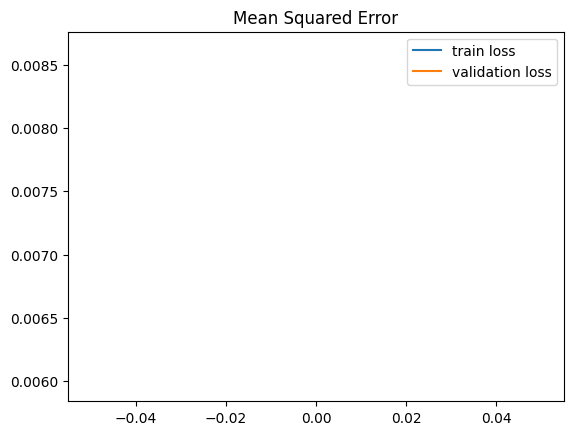

In [16]:
# Trainig
#build live matplotlib fig
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

LOAD_MODEL = False
if LOAD_MODEL:
    load_ckpt("{}/checkpoints/epoch_{}_ckpts.pt".format(os.getcwd(), epoch), model, optimizer)
scaler = torch.cuda.amp.GradScaler()
print(scaler)
best_val_loss = float('inf')
writer = SummaryWriter("run/loss_plot")
step = 0
for epoch in range(1, epochs+1):
    print(f'Epoch #{epoch}')
    epoch_start_time = time.time()
    train_loss, train_pearsonr = train(model, train_dataloader, optimizer, scaler, writer, step)
#     print(train_loss)
    train_losses.append(train_loss)
    mean_loss = sum(train_losses)/len(train_losses)
    val_loss = validate(model, val_dataloader)
    val_losses.append(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.4f} | mean loss {mean_loss:8.4f}')
    print('-' * 89)
    ax.clear()
    ax.plot(mean_loss, label='train loss')
    ax.plot(val_loss.cpu(), label='validation loss')
    ax.set_title("Mean Squared Error")
    ax.legend()
    fig.canvas.draw()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # save model
#         save_ckpt("{}/checkpoints/epoch_{}_ckpts.pt".format(os.getcwd(), epoch), model, optimizer,epochs, val_loss)
        save_ckpt("{}/checkpoints".format(os.getcwd(), epoch), model, optimizer,epochs, train_losses, val_losses)

    # scheduler.step(mean_loss)
    scheduler.step()
# load_ckpt("/content/drive/MyDrive/checkpoints.pt", model, optimizer)


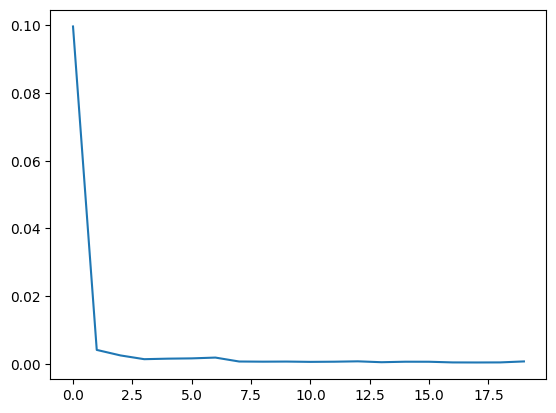

In [30]:
plt.figure
plt.plot(train_losses)
plt.show()

In [34]:
val_losses.cpu()

AttributeError: 'list' object has no attribute 'cpu'